In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import load_img
from keras.applications.vgg16 import preprocess_input 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from random import randint
import pandas as pd
from ReadData import *

KeyboardInterrupt: 

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
def readData(path):
    data = getEMData(path)
    target = []
    field = []
    freq = []

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)

    return field, target, freq

In [6]:
fieldRange, targetRange, freqRange = readData("./20FreqInRange/")

Read 1000 samples


In [7]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [9]:
path = "D:/UManitoba/Terms/Fall 2023/Data 4010/Python Script/FreqInRangeImg"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
imgs = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            imgs.append(file.name)

In [10]:
img = np.array(load_img(imgs[0], target_size=(224,224)))
img.reshape(1,224,224,3).shape

(1, 224, 224, 3)

In [11]:
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [12]:
data = {}
# lop through each image in the dataset
for i in imgs:
    feat = extract_features(i,model)
    data[i] = feat


1/1 [==============================] - 0s 313ms/step


In [15]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

In [16]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=576, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=3, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=3, random_state=22)

In [17]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (24,24))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 10 images to be shown at a time
    if len(files) > 10:
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [18]:
[len(groups[0]),len(groups[1]),len(groups[2])]

[260, 341, 399]

In [19]:
def extract_num(string):
    return int(string.split('_')[2].split('.')[0])

def get_freq(grp):
    frequency = {}
    for i in range(0,len(grp)):
        frequency[i] = []
        nums = list(filter(lambda x: x is not None,map(extract_num, grp[i])))   
        frequency[i] = freqRange[nums]
    return frequency

In [20]:
frequency = get_freq(groups)
[sum(frequency[0])/len(frequency[0]), sum(frequency[1])/len(frequency[1]), sum(frequency[2])/len(frequency[2])]

[1552618103.596735, 2646974582.3055525, 1672967490.7685263]

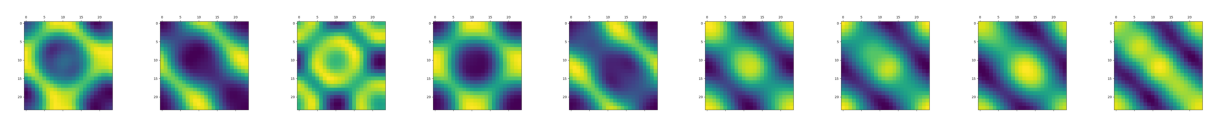

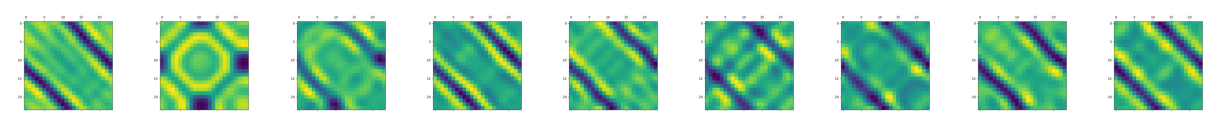

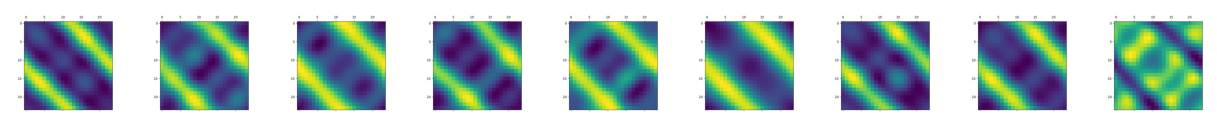

In [21]:
view_cluster(0)
view_cluster(1)
view_cluster(2)

Text(0, 0.5, 'Sum of squared distance')

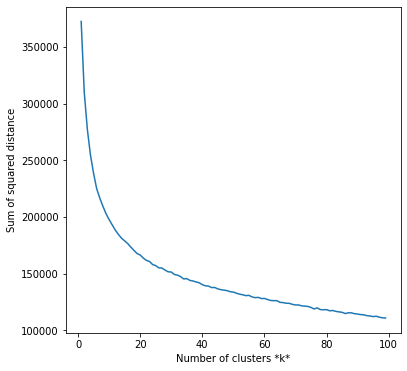

In [28]:
#which value for k might be the best 
sse = []
list_k = list(range(1, 100))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)   
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

Text(0, 0.5, 'Sum of squared distance')

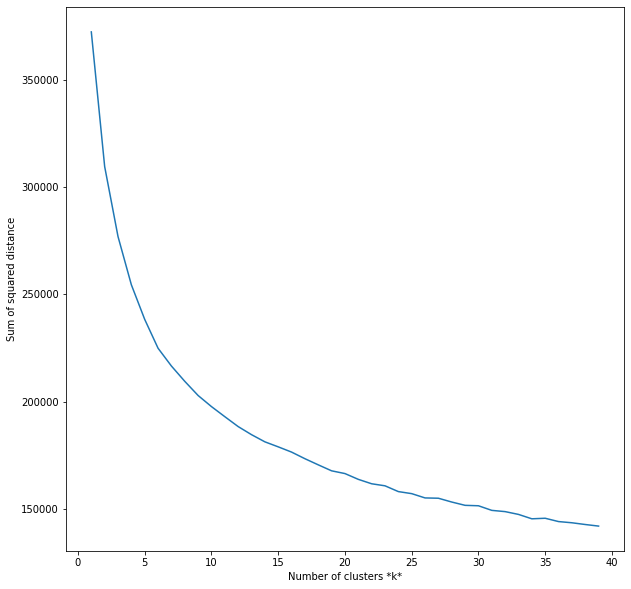

In [31]:
#see which value for k might be the best 
sse = []
list_k = list(range(1, 40))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)   
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [32]:
from sklearn.metrics import silhouette_score
silhouette_score(x, kmeans.labels_)

0.1466586

In [3]:
import numpy as np
# Create a random array of shape (5, 3, 3)
arr = np.random.random((3, 2, 2))

# Reshape the array to add an extra dimension of size 1

print(arr)

[[[0.6830596  0.21157196]
  [0.81452899 0.83143016]]

 [[0.22881173 0.09295441]
  [0.46790059 0.37458861]]

 [[0.33877836 0.18046186]
  [0.40056263 0.14544547]]]


In [6]:
arr_reshaped = np.reshape(arr, (3, 2, 2, 1))

print(arr_reshaped)

[[[[0.6830596 ]
   [0.21157196]]

  [[0.81452899]
   [0.83143016]]]


 [[[0.22881173]
   [0.09295441]]

  [[0.46790059]
   [0.37458861]]]


 [[[0.33877836]
   [0.18046186]]

  [[0.40056263]
   [0.14544547]]]]


In [40]:
# cluster feature vectors
kmeans = KMeans(n_clusters=6, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=6, random_state=22)

In [41]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

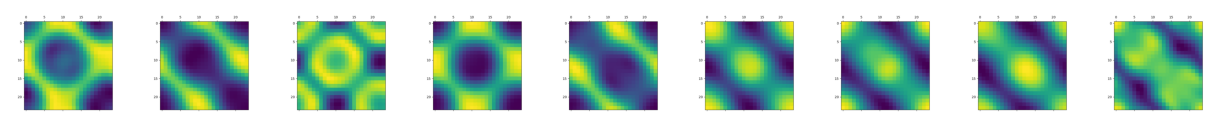

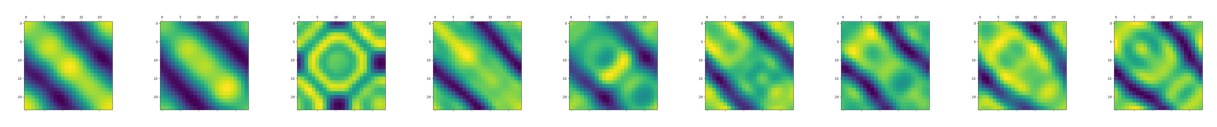

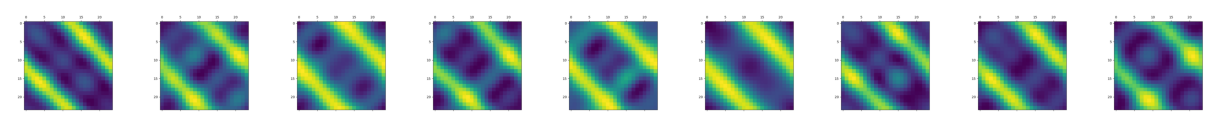

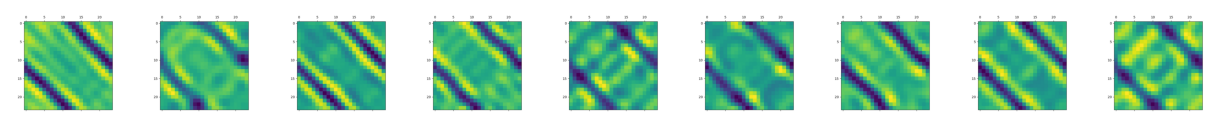

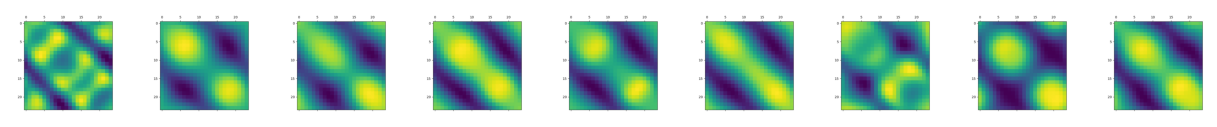

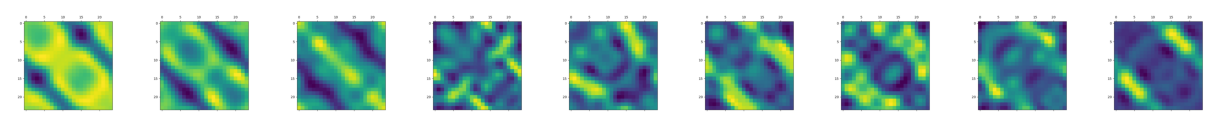

In [35]:
for i in range(len(groups)):
    view_cluster(i)

In [42]:
silhouette_score(x, kmeans.labels_)

0.14713043

In [15]:
import random
random.gauss(2.7, 0.25)

2.5205082949609343

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_weights/", monitor="val_loss", mode="min", save_best_only=True, 
                                                verbose=0, overwrite=True)
earlyStop = EarlyStopping(monitor='loss',patience=3)

model_mnist_padded.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr), loss = 'mean_squared_error', 
                    metrics = 'accuracy')
hist_padded = model_mnist_padded.fit(x = fieldMNIST_train_padded, y = targetMNIST_train, 
                                    validation_data=(fieldMNIST_val_padded, targetMNIST_val), 
                                    batch_size = 10, epochs = total_epoch, 
                                    callbacks = [earlyStop, checkpoint])

Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.5163

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 418ms/step - loss: 0.2850 - accuracy: 0.5163 - val_loss: 0.2570 - val_accuracy: 0.3207
Epoch 2/200
41/41 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.6399

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 470ms/step - loss: 0.2421 - accuracy: 0.6399 - val_loss: 0.2495 - val_accuracy: 0.5140
Epoch 3/200
41/41 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.7059

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 407ms/step - loss: 0.2147 - accuracy: 0.7059 - val_loss: 0.2344 - val_accuracy: 0.6470
Epoch 4/200
41/41 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.7393

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 20s 494ms/step - loss: 0.1961 - accuracy: 0.7393 - val_loss: 0.2202 - val_accuracy: 0.6768
Epoch 5/200
41/41 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.7663

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 411ms/step - loss: 0.1799 - accuracy: 0.7663 - val_loss: 0.2128 - val_accuracy: 0.6793
Epoch 6/200
41/41 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.7857

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 407ms/step - loss: 0.1673 - accuracy: 0.7857 - val_loss: 0.2085 - val_accuracy: 0.6793
Epoch 7/200
41/41 [==============================] - 13s 309ms/step - loss: 0.1552 - accuracy: 0.8024 - val_loss: 0.2104 - val_accuracy: 0.6793
Epoch 8/200
41/41 [==============================] - 13s 311ms/step - loss: 0.1452 - accuracy: 0.8159 - val_loss: 0.2145 - val_accuracy: 0.6793
Epoch 9/200
41/41 [==============================] - 13s 317ms/step - loss: 0.1351 - accuracy: 0.8294 - val_loss: 0.2270 - val_accuracy: 0.6793
Epoch 10/200
41/41 [==============================] - 13s 310ms/step - loss: 0.1266 - accuracy: 0.8408 - val_loss: 0.2268 - val_accuracy: 0.6793
Epoch 11/200
41/41 [==============================] - 14s 332ms/step - loss: 0.1178 - accuracy: 0.8528 - val_loss: 0.2300 - val_accuracy: 0.6795
Epoch 12/200
41/41 [==============================] - 18s 441ms/step - loss: 0.1101 - accuracy: 0.8630 - val_loss: 0.2198 - val_accuracy: 0.6829
E

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 416ms/step - loss: 0.0985 - accuracy: 0.8777 - val_loss: 0.1945 - val_accuracy: 0.7036
Epoch 15/200
41/41 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.8869

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 15s 380ms/step - loss: 0.0919 - accuracy: 0.8869 - val_loss: 0.1820 - val_accuracy: 0.7215
Epoch 16/200
41/41 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.8936

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 450ms/step - loss: 0.0864 - accuracy: 0.8936 - val_loss: 0.1724 - val_accuracy: 0.7362
Epoch 17/200
41/41 [==============================] - ETA: 0s - loss: 0.0832 - accuracy: 0.8977

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 439ms/step - loss: 0.0832 - accuracy: 0.8977 - val_loss: 0.1531 - val_accuracy: 0.7660
Epoch 18/200
41/41 [==============================] - ETA: 0s - loss: 0.0787 - accuracy: 0.9031

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 442ms/step - loss: 0.0787 - accuracy: 0.9031 - val_loss: 0.1182 - val_accuracy: 0.8271
Epoch 19/200
41/41 [==============================] - 15s 357ms/step - loss: 0.0754 - accuracy: 0.9073 - val_loss: 0.1244 - val_accuracy: 0.8174
Epoch 20/200
41/41 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9127

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 20s 487ms/step - loss: 0.0714 - accuracy: 0.9127 - val_loss: 0.1153 - val_accuracy: 0.8327
Epoch 21/200
41/41 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9151

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 456ms/step - loss: 0.0694 - accuracy: 0.9151 - val_loss: 0.0972 - val_accuracy: 0.8666
Epoch 22/200
41/41 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9201

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 472ms/step - loss: 0.0657 - accuracy: 0.9201 - val_loss: 0.0927 - val_accuracy: 0.8754
Epoch 23/200
41/41 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9225

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 418ms/step - loss: 0.0638 - accuracy: 0.9225 - val_loss: 0.0900 - val_accuracy: 0.8806
Epoch 24/200
41/41 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9252

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 429ms/step - loss: 0.0616 - accuracy: 0.9252 - val_loss: 0.0889 - val_accuracy: 0.8827
Epoch 25/200
41/41 [==============================] - 13s 316ms/step - loss: 0.0591 - accuracy: 0.9283 - val_loss: 0.0920 - val_accuracy: 0.8751
Epoch 26/200
41/41 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9320

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 16s 394ms/step - loss: 0.0567 - accuracy: 0.9320 - val_loss: 0.0872 - val_accuracy: 0.8851
Epoch 27/200
41/41 [==============================] - 14s 350ms/step - loss: 0.0561 - accuracy: 0.9319 - val_loss: 0.0879 - val_accuracy: 0.8832
Epoch 28/200
41/41 [==============================] - 14s 343ms/step - loss: 0.0538 - accuracy: 0.9354 - val_loss: 0.0882 - val_accuracy: 0.8812
Epoch 29/200
41/41 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9372

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 22s 538ms/step - loss: 0.0525 - accuracy: 0.9372 - val_loss: 0.0848 - val_accuracy: 0.8898
Epoch 30/200
41/41 [==============================] - 13s 320ms/step - loss: 0.0507 - accuracy: 0.9393 - val_loss: 0.0855 - val_accuracy: 0.8874
Epoch 31/200
41/41 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9399

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 441ms/step - loss: 0.0501 - accuracy: 0.9399 - val_loss: 0.0848 - val_accuracy: 0.8890
Epoch 32/200
41/41 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9417

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 17s 430ms/step - loss: 0.0486 - accuracy: 0.9417 - val_loss: 0.0839 - val_accuracy: 0.8900
Epoch 33/200
41/41 [==============================] - 14s 344ms/step - loss: 0.0468 - accuracy: 0.9442 - val_loss: 0.0852 - val_accuracy: 0.8870
Epoch 34/200
41/41 [==============================] - ETA: 0s - loss: 0.0457 - accuracy: 0.9458

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 16s 394ms/step - loss: 0.0457 - accuracy: 0.9458 - val_loss: 0.0833 - val_accuracy: 0.8912
Epoch 35/200
41/41 [==============================] - 14s 337ms/step - loss: 0.0452 - accuracy: 0.9458 - val_loss: 0.0838 - val_accuracy: 0.8887
Epoch 36/200
41/41 [==============================] - 13s 324ms/step - loss: 0.0433 - accuracy: 0.9485 - val_loss: 0.0837 - val_accuracy: 0.8880
Epoch 37/200
41/41 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9501

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 460ms/step - loss: 0.0423 - accuracy: 0.9501 - val_loss: 0.0828 - val_accuracy: 0.8896
Epoch 38/200
41/41 [==============================] - 15s 380ms/step - loss: 0.0416 - accuracy: 0.9509 - val_loss: 0.0877 - val_accuracy: 0.8801
Epoch 39/200
41/41 [==============================] - 16s 396ms/step - loss: 0.0413 - accuracy: 0.9509 - val_loss: 0.0832 - val_accuracy: 0.8895
Epoch 40/200
41/41 [==============================] - 13s 322ms/step - loss: 0.0398 - accuracy: 0.9531 - val_loss: 0.0831 - val_accuracy: 0.8894
Epoch 41/200
41/41 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9533

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 448ms/step - loss: 0.0394 - accuracy: 0.9533 - val_loss: 0.0825 - val_accuracy: 0.8902
Epoch 42/200
41/41 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9550

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 18s 434ms/step - loss: 0.0384 - accuracy: 0.9550 - val_loss: 0.0816 - val_accuracy: 0.8911
Epoch 43/200
41/41 [==============================] - 14s 352ms/step - loss: 0.0370 - accuracy: 0.9568 - val_loss: 0.0860 - val_accuracy: 0.8835
Epoch 44/200
41/41 [==============================] - 15s 358ms/step - loss: 0.0391 - accuracy: 0.9530 - val_loss: 0.0826 - val_accuracy: 0.8935
Epoch 45/200
41/41 [==============================] - 13s 326ms/step - loss: 0.0371 - accuracy: 0.9560 - val_loss: 0.0817 - val_accuracy: 0.8916
Epoch 46/200
41/41 [==============================] - 13s 323ms/step - loss: 0.0348 - accuracy: 0.9594 - val_loss: 0.0850 - val_accuracy: 0.8922
Epoch 47/200
41/41 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9589

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 19s 477ms/step - loss: 0.0350 - accuracy: 0.9589 - val_loss: 0.0807 - val_accuracy: 0.8939
Epoch 48/200
41/41 [==============================] - 14s 332ms/step - loss: 0.0342 - accuracy: 0.9603 - val_loss: 0.0826 - val_accuracy: 0.8892
Epoch 49/200
41/41 [==============================] - 14s 335ms/step - loss: 0.0337 - accuracy: 0.9608 - val_loss: 0.0816 - val_accuracy: 0.8924
Epoch 50/200
41/41 [==============================] - 16s 395ms/step - loss: 0.0332 - accuracy: 0.9613 - val_loss: 0.0815 - val_accuracy: 0.8914
Epoch 51/200
41/41 [==============================] - 20s 488ms/step - loss: 0.0324 - accuracy: 0.9625 - val_loss: 0.0819 - val_accuracy: 0.8905
Epoch 52/200
41/41 [==============================] - 15s 353ms/step - loss: 0.0322 - accuracy: 0.9626 - val_loss: 0.0809 - val_accuracy: 0.8948
Epoch 53/200
41/41 [==============================] - 14s 355ms/step - loss: 0.0306 - accuracy: 0.9650 - val_loss: 0.0809 - val_accuracy: 0.892

INFO:tensorflow:Assets written to: ./model_weights\assets


INFO:tensorflow:Assets written to: ./model_weights\assets


41/41 [==============================] - 22s 543ms/step - loss: 0.0305 - accuracy: 0.9648 - val_loss: 0.0802 - val_accuracy: 0.8949
Epoch 55/200
41/41 [==============================] - 14s 340ms/step - loss: 0.0304 - accuracy: 0.9653 - val_loss: 0.0806 - val_accuracy: 0.8932
Epoch 56/200
41/41 [==============================] - 12s 295ms/step - loss: 0.0304 - accuracy: 0.9647 - val_loss: 0.0855 - val_accuracy: 0.8849
Epoch 57/200
41/41 [==============================] - 16s 398ms/step - loss: 0.0289 - accuracy: 0.9669 - val_loss: 0.0803 - val_accuracy: 0.8943
Epoch 58/200
41/41 [==============================] - 14s 333ms/step - loss: 0.0290 - accuracy: 0.9669 - val_loss: 0.0827 - val_accuracy: 0.8896
Epoch 59/200
41/41 [==============================] - 12s 298ms/step - loss: 0.0286 - accuracy: 0.9675 - val_loss: 0.0809 - val_accuracy: 0.8922
Epoch 60/200
41/41 [==============================] - 11s 278ms/step - loss: 0.0274 - accuracy: 0.9690 - val_loss: 0.0803 - val_accuracy: 0.893

In [ ]:
# from keras.models import save_model
model_mnist_padded.save('unet_padded.h5', overwrite=True)


In [ ]:
from keras.models import load_model

trained_model_padded = load_model('unet_padded.h5')

pred1 = trained_model_padded.predict(fieldMNIST_test_padded)

4/4 [==============================] - 1s 149ms/step


In [ ]:
# pred1 = model_mnist_padded.predict(fieldMNIST_test_padded)
pred1 = model_.predict(field_dif_perm_padded)
model_mnist_padded.evaluate(field_dif_perm_padded, target_dif_perm_transformed)

20/20 [==============================] - 4s 186ms/step - loss: 0.4315 - accuracy: 0.5855


[0.43149253726005554, 0.5854915976524353]

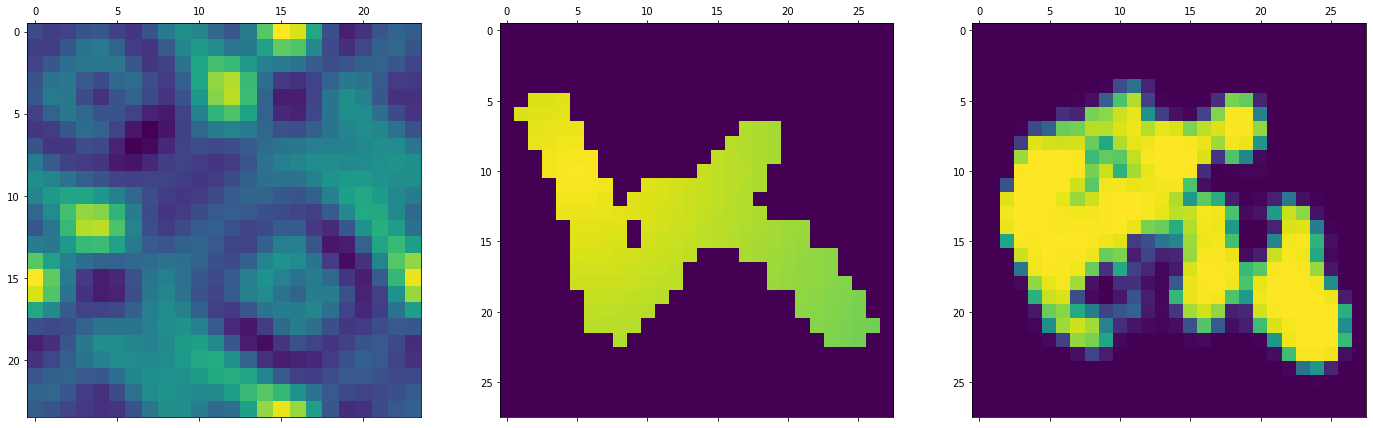

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

# axs[0].matshow(fieldMNIST_test[5])
# axs[1].matshow(targetMNIST_test[5])
axs[0].matshow(field_dif_perm_transformed[5])
axs[1].matshow(target_dif_perm_transformed[5])
axs[2].matshow(pred1[5])

plt.show()

In [ ]:
trained_model_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)
# model_mnist_padded.evaluate(fieldMNIST_test_padded, targetMNIST_test)

4/4 [==============================] - 1s 140ms/step - loss: 0.0834 - accuracy: 0.8900


[0.08337408304214478, 0.8900328278541565]

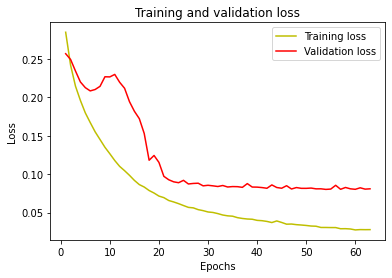

In [ ]:
loss = hist_padded.history['loss']
val_loss = hist_padded.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

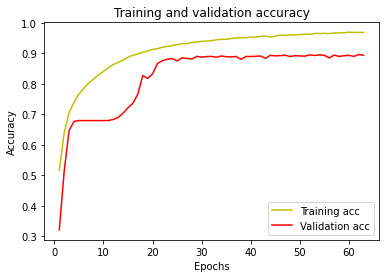

In [ ]:
acc = hist_padded.history['accuracy']
val_acc = hist_padded.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
losses = []
val_losses = []
accuracy = []
val_accuracy = []
histories = []
for train_index, val_index in kf.split(fieldMNIST_train_padded):
    print('   ')
    print(f'Training for fold {fold} ...')

    X_train, X_val = fieldMNIST_train_f_padded[train_index], fieldMNIST_train_f_padded[val_index]
    y_train, y_val = targetMNIST_train_full[train_index], targetMNIST_train_full[val_index]

    model = unet_padded(input_shape=X_train.shape[1:])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics='accuracy')
    early_stopping = EarlyStopping(monitor='loss', patience=10)

    # Train the model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=100, 
                        batch_size=20,
                        callbacks=[early_stopping],
                        verbose=1)
    # Store history
    histories.append(history.history)
    val_losses.append(min(history.history['val_loss']))

    # Plot loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

    losses.append(min(history.history['loss']))
    val_losses.append(min(history.history['val_loss']))
    accuracy.append(min(history.history['accuracy']))
    val_accuracy.append(min(history.history['val_accuracy']))

    fold += 1